<a href="https://colab.research.google.com/github/IvanIsCoding/GNN-for-Combinatiorial-Optimization/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://arxiv.org/abs/2107.01188

In [452]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f01107e0-6621-1c94-a13f-8fe2f305cd69)


In [453]:
!pip install -q flax pyqubo

In [454]:
import jax
import jax.numpy as jnp
import numpy as np
import networkx as nx # for making graphs
import optax # for optimizing GNN with Adam

from flax import linen as nn # for defining the GNN
from flax.training import train_state # utility for training
from pyqubo import Array # for defining the QUBO
from tqdm.notebook import trange, tqdm # visualizing notebook progress

In [455]:
def create_max_cut_model(graph):
  N = graph.number_of_nodes()
  X = Array.create("X", shape=(N,), vartype="BINARY")

  hamiltonian = 0
  for u, v in graph.edges:
    hamiltonian -= (X[u] - X[v])**2
  
  return hamiltonian.compile()

def create_mis_model(graph, penalty=2):
  N = graph.number_of_nodes()
  X = Array.create("X", shape=(N,), vartype="BINARY")

  hamiltonian = -sum(X)
  for u, v in graph.edges:
    hamiltonian += penalty * (X[u] * X[v])

  return hamiltonian.compile()

def create_Q_matrix(graph, is_max_cut=True):
  if is_max_cut:
    model = create_max_cut_model(graph)
  else:
    model = create_mis_model(graph)
  
  N = graph.number_of_nodes()
  extract_val = lambda x: int(x[2:-1])
  Q_matrix = np.zeros((N, N))

  qubo_dict, _ = model.to_qubo()

  for (a, b), quv in qubo_dict.items():
    u = min(extract_val(a), extract_val(b))
    v = max(extract_val(a), extract_val(b))
    Q_matrix[u,v] = quv

  return jnp.array(Q_matrix)

In [456]:
def qubo_approx_cost(probs, Q):
  cost = jnp.sum(
      jnp.matmul(
          jnp.matmul(jnp.transpose(probs), Q), 
          probs
      )
  )
  return cost  

In [457]:
def compute_metrics(*, probs, q_matrix):
  energy = qubo_approx_cost(probs=probs, Q=q_matrix)
  metrics = {
      "energy": energy,
  }
  return metrics

In [458]:
class GraphConvLayer(nn.Module):
    c_out : int  # Output feature size

    @nn.compact
    def __call__(self, node_feats, adj_matrix):
        node_feats_w1 = nn.Dense(features=self.c_out, use_bias=False)(node_feats)
        node_feats_w2 = jax.lax.batch_matmul(adj_matrix, node_feats)
        node_feats_w2 = nn.Dense(features=self.c_out)(node_feats_w2)
        return node_feats_w1 + node_feats_w2

In [459]:
class CombGNN(nn.Module):
    hidden_size: int
    num_classes: int
    dropout_frac: float

    @nn.compact
    def __call__(self, node_feats, adj_matrix):
        # First convolution
        h = GraphConvLayer(c_out=self.hidden_size)(node_feats=node_feats, adj_matrix=adj_matrix)
        h = nn.relu(h)
        #h = nn.Dropout(self.dropout_frac)
        # Second convolution
        h = GraphConvLayer(c_out=self.num_classes)(node_feats=h, adj_matrix=adj_matrix)
        probs = nn.sigmoid(h)

        return probs

In [460]:
def create_train_state(n_vertices, embedding_size, hidden_size, rng, learning_rate, dropout_frac=0.0):
  gnn = CombGNN(hidden_size = hidden_size, num_classes=1, dropout_frac=dropout_frac)
  params = gnn.init(rng, node_feats=jnp.ones([n_vertices, embedding_size]), adj_matrix=jnp.ones([n_vertices, n_vertices]))["params"]
  tx = optax.adam(learning_rate)
  return train_state.TrainState.create(apply_fn = gnn.apply, params=params, tx=tx)

In [461]:
@jax.jit
def train_step(state, node_embeddings, adj_matrix, q_matrix):
  """Train for a single step."""
  def cost_fn(params):
    probs = state.apply_fn({'params': params}, node_embeddings, adj_matrix)
    cost = qubo_approx_cost(probs=probs, Q=q_matrix)
    return cost, probs
  grad_fn = jax.grad(cost_fn, has_aux=True)
  grads, probs = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(probs=probs, q_matrix=q_matrix)
  return state, metrics

In [462]:
def get_classification(apply_fn, node_embedding, adj_matrix):
  pred_probs = state.apply_fn({'params': state.params}, node_embeddings, adj_matrix)
  classification = jnp.where(
      pred_probs >= 0.5, 1, 0 
  )
  return np.ravel(classification)

# Max-Cut On Example Graph



In [463]:
edgelist = [(0, 1), (1, 2), (2, 3), (3, 0), (1, 4), (2, 4)]
G = nx.from_edgelist(edgelist)

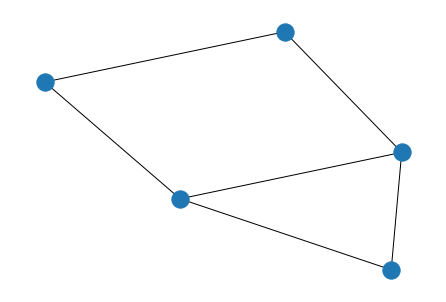

In [464]:
nx.draw(G, pos=nx.spring_layout(G, seed=2023))

In [465]:
A = jnp.array(nx.to_numpy_array(G))

In [466]:
A

DeviceArray([[0., 1., 0., 1., 0.],
             [1., 0., 1., 0., 1.],
             [0., 1., 0., 1., 1.],
             [1., 0., 1., 0., 0.],
             [0., 1., 1., 0., 0.]], dtype=float32)

In [467]:
Q = create_Q_matrix(G)

In [468]:
Q

DeviceArray([[-2.,  2.,  0.,  2.,  0.],
             [ 0., -3.,  2.,  0.,  2.],
             [ 0.,  0., -3.,  2.,  2.],
             [ 0.,  0.,  0., -2.,  0.],
             [ 0.,  0.,  0.,  0., -2.]], dtype=float32)

In [469]:
rng = jax.random.PRNGKey(2023)
rng, init_rng = jax.random.split(rng)
rng, embed_rng = jax.random.split(rng)

In [470]:
learning_rate = 0.005

In [471]:
embedding_d0 = 5
embedding_d1 = embedding_d0//2

In [472]:
state = create_train_state(G.number_of_nodes(), embedding_d0, embedding_d1, init_rng, learning_rate)

In [473]:
node_embeddings = jax.random.uniform(embed_rng, [G.number_of_nodes(), embedding_d0])

In [474]:
node_embeddings

DeviceArray([[0.90081596, 0.38583064, 0.02542734, 0.7263125 , 0.77239466],
             [0.13210392, 0.2291317 , 0.15860796, 0.39851677, 0.9010197 ],
             [0.5372865 , 0.6941434 , 0.948866  , 0.5196214 , 0.97492456],
             [0.13318086, 0.49488008, 0.6443068 , 0.95046246, 0.5960568 ],
             [0.19223976, 0.44076335, 0.9235079 , 0.26473606, 0.49318063]],            dtype=float32)

In [475]:
num_epochs = 500

In [476]:
for epoch in trange(1, num_epochs + 1):
  state, metrics = train_step(state=state, node_embeddings=node_embeddings, adj_matrix=A, q_matrix=Q)

  if epoch % 25 == 0:
    print('train epoch: %d, cost: %.2f' % (epoch, metrics["energy"]))

  0%|          | 0/500 [00:00<?, ?it/s]

train epoch: 25, cost: -0.34
train epoch: 50, cost: -2.10
train epoch: 75, cost: -3.84
train epoch: 100, cost: -4.42
train epoch: 125, cost: -4.66
train epoch: 150, cost: -4.78
train epoch: 175, cost: -4.84
train epoch: 200, cost: -4.88
train epoch: 225, cost: -4.91
train epoch: 250, cost: -4.93
train epoch: 275, cost: -4.94
train epoch: 300, cost: -4.95
train epoch: 325, cost: -4.96
train epoch: 350, cost: -4.96
train epoch: 375, cost: -4.97
train epoch: 400, cost: -4.97
train epoch: 425, cost: -4.97
train epoch: 450, cost: -4.98
train epoch: 475, cost: -4.98
train epoch: 500, cost: -4.98


In [477]:
state.apply_fn({'params': state.params}, node_embeddings, A)

DeviceArray([[9.9998617e-01],
             [2.1988944e-04],
             [9.9997127e-01],
             [2.0501104e-03],
             [9.9555635e-01]], dtype=float32)

In [478]:
classification = get_classification(state.apply_fn, node_embeddings, A)

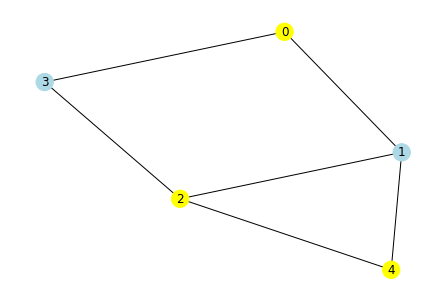

In [479]:
nx.draw(G, pos=nx.spring_layout(G, seed=2023), node_color=["yellow" if c else "lightblue" for c in classification], with_labels=True)

# Maximum Independet Set on Example Graph

In [480]:
A = jnp.array(nx.to_numpy_array(G))
Q = create_Q_matrix(G, is_max_cut=False)

In [481]:
Q

DeviceArray([[-1.,  2.,  0.,  2.,  0.],
             [ 0., -1.,  2.,  0.,  2.],
             [ 0.,  0., -1.,  2.,  2.],
             [ 0.,  0.,  0., -1.,  0.],
             [ 0.,  0.,  0.,  0., -1.]], dtype=float32)

In [482]:
rng = jax.random.PRNGKey(666) # yeah I know
rng, init_rng = jax.random.split(rng)
rng, embed_rng = jax.random.split(rng)

In [483]:
learning_rate = 0.01

In [484]:
embedding_d0 = 5
embedding_d1 = embedding_d0//2

In [485]:
state = create_train_state(G.number_of_nodes(), embedding_d0, embedding_d1, init_rng, learning_rate)

In [486]:
node_embeddings = jax.random.uniform(embed_rng, [G.number_of_nodes(), embedding_d0])

In [487]:
num_epochs = 500

In [488]:
for epoch in trange(1, num_epochs + 1):
  state, metrics = train_step(state=state, node_embeddings=node_embeddings, adj_matrix=A, q_matrix=Q)

  if epoch % 25 == 0:
    print('train epoch: %d, cost: %.2f' % (epoch, metrics["energy"]))

  0%|          | 0/500 [00:00<?, ?it/s]

train epoch: 25, cost: -0.01
train epoch: 50, cost: -0.01
train epoch: 75, cost: -0.07
train epoch: 100, cost: -0.61
train epoch: 125, cost: -1.60
train epoch: 150, cost: -1.89
train epoch: 175, cost: -1.94
train epoch: 200, cost: -1.96
train epoch: 225, cost: -1.97
train epoch: 250, cost: -1.98
train epoch: 275, cost: -1.98
train epoch: 300, cost: -1.99
train epoch: 325, cost: -1.99
train epoch: 350, cost: -1.99
train epoch: 375, cost: -1.99
train epoch: 400, cost: -1.99
train epoch: 425, cost: -1.99
train epoch: 450, cost: -1.99
train epoch: 475, cost: -1.99
train epoch: 500, cost: -2.00


In [489]:
classification = get_classification(state.apply_fn, node_embeddings, A)

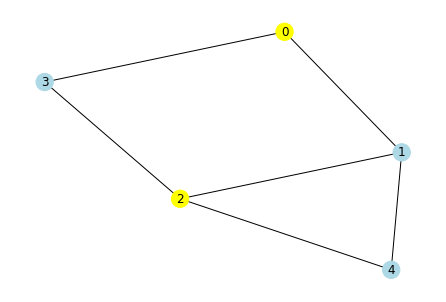

In [490]:
nx.draw(G, pos=nx.spring_layout(G, seed=2023), node_color=["yellow" if c else "lightblue" for c in classification], with_labels=True)

# Max-Cut on Larger Graph


In [491]:
G = nx.convert_node_labels_to_integers(nx.fast_gnp_random_graph(n = 100, p=0.05, seed=2023))
A = jnp.array(nx.to_numpy_array(G))
Q = create_Q_matrix(G)

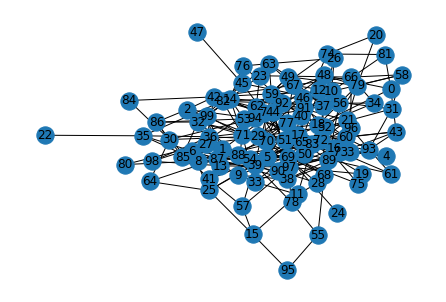

In [492]:
nx.draw(G, pos=nx.spring_layout(G, seed=2023), with_labels=True)

In [493]:
embedding_d0 = int(np.sqrt(G.number_of_nodes()))
embedding_d1 = embedding_d0//2

In [494]:
rng = jax.random.PRNGKey(2023)
rng, init_rng = jax.random.split(rng)
rng, embed_rng = jax.random.split(rng)
state = create_train_state(G.number_of_nodes(), embedding_d0, embedding_d1, init_rng, learning_rate)

In [495]:
node_embeddings = jax.random.uniform(embed_rng, [G.number_of_nodes(), embedding_d0])

In [496]:
num_epochs = 1000

In [497]:
for epoch in trange(1, num_epochs + 1):
  state, metrics = train_step(state=state, node_embeddings=node_embeddings, adj_matrix=A, q_matrix=Q)

  if epoch % 25 == 0:
    print('train epoch: %d, cost: %.2f' % (epoch, metrics["energy"]))

  0%|          | 0/1000 [00:00<?, ?it/s]

train epoch: 25, cost: -118.76
train epoch: 50, cost: -162.09
train epoch: 75, cost: -177.97
train epoch: 100, cost: -184.06
train epoch: 125, cost: -187.81
train epoch: 150, cost: -189.92
train epoch: 175, cost: -191.24
train epoch: 200, cost: -192.13
train epoch: 225, cost: -192.74
train epoch: 250, cost: -193.18
train epoch: 275, cost: -193.50
train epoch: 300, cost: -193.75
train epoch: 325, cost: -193.93
train epoch: 350, cost: -194.08
train epoch: 375, cost: -194.20
train epoch: 400, cost: -194.30
train epoch: 425, cost: -194.38
train epoch: 450, cost: -194.45
train epoch: 475, cost: -194.50
train epoch: 500, cost: -194.55
train epoch: 525, cost: -194.59
train epoch: 550, cost: -194.63
train epoch: 575, cost: -194.66
train epoch: 600, cost: -194.69
train epoch: 625, cost: -194.71
train epoch: 650, cost: -194.73
train epoch: 675, cost: -194.75
train epoch: 700, cost: -194.77
train epoch: 725, cost: -194.79
train epoch: 750, cost: -194.80
train epoch: 775, cost: -194.81
train epoch

In [498]:
classification = get_classification(state.apply_fn, node_embeddings, A)

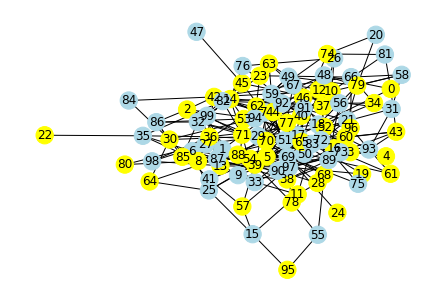

In [499]:
nx.draw(G, pos=nx.spring_layout(G, seed=2023), node_color=["yellow" if c else "lightblue" for c in classification], with_labels=True)

In [500]:
[]

[]